<a href="https://colab.research.google.com/github/K10KI/K10KI/blob/main/Wesad_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pickle

# 指定包含 .pkl 文件的根目录
root_dir = '/content/drive/My Drive/WESAD'

# 确保根目录存在
if os.path.exists(root_dir):
    print(f"根目录 {root_dir} 存在")
else:
    print(f"根目录 {root_dir} 不存在")

# 遍历目录，找到所有 .pkl 文件
for subdir, dirs, files in os.walk(root_dir):
    print(f"遍历目录: {subdir}")
    for file in files:
        if file.endswith('.pkl'):
            file_path = os.path.join(subdir, file)
            print(f"处理文件: {file_path}")
            try:
                with open(file_path, 'rb') as f:
                    data = pickle.load(f, encoding='latin1')  # 使用 latin1 编码
                    # 验证数据加载
                    print(f"文件 {file_path} 加载成功，数据类型: {type(data)}")
            except Exception as e:
                print(f"加载文件 {file_path} 时发生错误: {e}")

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.pkl'):
            file_path = os.path.join(subdir, file)
            print(f"处理文件: {file_path}")
            try:
                with open(file_path, 'rb') as f:
                    data = pickle.load(f, encoding='latin1')
                    # 查看字典中的键
                    print(f"字典键：{data.keys()}")
                    # 示例打印某些具体键的内容
                    if 'signal' in data:
                        print(f"信号键：{data['signal'].keys()}")
                        if 'chest' in data['signal']:
                            print(f"胸部信号键：{data['signal']['chest'].keys()}")
                        if 'wrist' in data['signal']:
                            print(f"手腕信号键：{data['signal']['wrist'].keys()}")
                    if 'label' in data:
                        print(f"标签数据类型：{type(data['label'])}")
            except Exception as e:
                print(f"加载文件 {file_path} 时发生错误: {e}")


Mounted at /content/drive
根目录 /content/drive/My Drive/WESAD 存在
遍历目录: /content/drive/My Drive/WESAD
遍历目录: /content/drive/My Drive/WESAD/S15
处理文件: /content/drive/My Drive/WESAD/S15/S15.pkl
文件 /content/drive/My Drive/WESAD/S15/S15.pkl 加载成功，数据类型: <class 'dict'>
遍历目录: /content/drive/My Drive/WESAD/S9
处理文件: /content/drive/My Drive/WESAD/S9/S9.pkl
文件 /content/drive/My Drive/WESAD/S9/S9.pkl 加载成功，数据类型: <class 'dict'>
遍历目录: /content/drive/My Drive/WESAD/S11
处理文件: /content/drive/My Drive/WESAD/S11/S11.pkl
文件 /content/drive/My Drive/WESAD/S11/S11.pkl 加载成功，数据类型: <class 'dict'>
遍历目录: /content/drive/My Drive/WESAD/S13
处理文件: /content/drive/My Drive/WESAD/S13/S13.pkl
文件 /content/drive/My Drive/WESAD/S13/S13.pkl 加载成功，数据类型: <class 'dict'>
遍历目录: /content/drive/My Drive/WESAD/S14
处理文件: /content/drive/My Drive/WESAD/S14/S14.pkl
文件 /content/drive/My Drive/WESAD/S14/S14.pkl 加载成功，数据类型: <class 'dict'>
遍历目录: /content/drive/My Drive/WESAD/S10
处理文件: /content/drive/My Drive/WESAD/S10/S10.pkl
文件 /content/drive/My Dr

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def extract_time_domain_features(signal):
    if len(signal) == 0:
        return {key: np.nan for key in ['mean', 'std', 'min', 'max', 'skewness', 'kurtosis', 'range']}
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal),
        'range': np.ptp(signal),
    }
    return features

def extract_frequency_domain_features(signal, fs=700):
    if len(signal) == 0:
        return {key: np.nan for key in ['freq_mean', 'freq_std', 'freq_max', 'freq_min', 'freq_peak', 'spectral_energy']}
    f, Pxx = welch(signal, fs=fs)
    features = {
        'freq_mean': np.mean(f),
        'freq_std': np.std(f),
        'freq_max': np.max(f),
        'freq_min': np.min(f),
        'freq_peak': f[np.argmax(Pxx)],
        'spectral_energy': np.sum(Pxx)
    }
    return features

def extract_acc_features(signal):
    features = {}
    for i, axis in enumerate(['x', 'y', 'z']):
        axis_signal = signal[:, i] if signal.shape[1] > i else np.array([])
        features.update({f'acc_{axis}_{key}': val for key, val in extract_time_domain_features(axis_signal).items()})
        features.update({f'acc_{axis}_{key}': val for key, val in extract_frequency_domain_features(axis_signal).items()})
    return features

def extract_features(signal, feature_extraction_func):
    return feature_extraction_func(signal)

def extract_features_from_data(data, window_size=700*10, step_size=700*5):
    features = []
    labels = []

    chest_data = data['signal']['chest']
    wrist_data = data['signal']['wrist']
    signal_labels = data['label']

    for start in range(0, len(signal_labels) - window_size, step_size):
        end = start + window_size
        if end > len(signal_labels):  # Check if window exceeds bounds
            break
        window_labels = signal_labels[start:end]
        window_label = np.bincount(window_labels).argmax()  # Majority vote

        window_features = {}

        # Extract features from chest signals
        for signal_type, extraction_func in zip(
            ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'],
            [extract_acc_features, extract_time_domain_features, extract_time_domain_features, extract_time_domain_features, extract_time_domain_features, extract_time_domain_features]):
            window_features.update({f'chest_{signal_type.lower()}_{key}': val for key, val in extract_features(chest_data[signal_type][start:end], extraction_func).items()})

        # Extract features from wrist signals
        for signal_type, extraction_func in zip(
            ['ACC', 'BVP', 'EDA', 'TEMP'],
            [extract_acc_features, extract_time_domain_features, extract_time_domain_features, extract_time_domain_features]):
            window_features.update({f'wrist_{signal_type.lower()}_{key}': val for key, val in extract_features(wrist_data[signal_type][start:end], extraction_func).items()})

        features.append(window_features)
        labels.append(window_label)

    return features, labels

# Iterate over all files and extract features
all_features = []
all_labels = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.pkl'):
            file_path = os.path.join(subdir, file)
            print(f"Processing file: {file_path}")
            try:
                with open(file_path, 'rb') as f:
                    data = pickle.load(f, encoding='latin1')
                    features, labels = extract_features_from_data(data)
                    all_features.extend(features)
                    all_labels.extend(labels)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

# Construct DataFrame
df_features = pd.DataFrame(all_features)
df_labels = pd.Series(all_labels)

print(df_features.head())
print(df_labels.head())

# Check for missing values
missing_values = df_features.isnull().sum()
print("Missing values per feature:\n", missing_values[missing_values > 0])


Processing file: /content/drive/My Drive/WESAD/S15/S15.pkl


/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  warnings.warn('nperseg = {0:d} is greater than input length '


Processing file: /content/drive/My Drive/WESAD/S9/S9.pkl
Processing file: /content/drive/My Drive/WESAD/S11/S11.pkl
Processing file: /content/drive/My Drive/WESAD/S13/S13.pkl
Processing file: /content/drive/My Drive/WESAD/S14/S14.pkl
Processing file: /content/drive/My Drive/WESAD/S10/S10.pkl
Processing file: /content/drive/My Drive/WESAD/S16/S16.pkl
Processing file: /content/drive/My Drive/WESAD/S8/S8.pkl
Processing file: /content/drive/My Drive/WESAD/S6/S6.pkl
Processing file: /content/drive/My Drive/WESAD/S7/S7.pkl
Processing file: /content/drive/My Drive/WESAD/S17/S17.pkl
Processing file: /content/drive/My Drive/WESAD/S4/S4.pkl
Processing file: /content/drive/My Drive/WESAD/S2/S2.pkl
Processing file: /content/drive/My Drive/WESAD/S3/S3.pkl
Processing file: /content/drive/My Drive/WESAD/S5/S5.pkl
   chest_acc_acc_x_mean  chest_acc_acc_x_std  chest_acc_acc_x_min  \
0              0.901122             0.023736               0.2574   
1              0.900818             0.003740        

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch

# Function to calculate RMSSD from HR data
def calculate_rmssd(hr_data):
    diff = np.diff(hr_data)
    return np.sqrt(np.mean(diff**2))

# Extract HR, RMSSD, and SCL from WESAD data
def extract_hr_rmssd_scl_from_wesad(data, window_size=700*10, step_size=700*5):
    features = []
    labels = []

    chest_data = data['signal']['chest']
    signal_labels = data['label']

    for start in range(0, len(signal_labels) - window_size, step_size):
        end = start + window_size
        if end > len(signal_labels):
            break
        window_labels = signal_labels[start:end]
        window_label = np.bincount(window_labels).argmax()

        window_features = {}

        # Extract HR from ECG
        hr_data = chest_data['ECG'][start:end]
        hr = np.mean(hr_data)  # Simplified HR extraction for example
        window_features['HR'] = hr

        # Calculate RMSSD
        rmssd = calculate_rmssd(hr_data)
        window_features['RMSSD'] = rmssd

        # Extract SCL from EDA
        scl_data = chest_data['EDA'][start:end]
        scl = np.mean(scl_data)
        window_features['SCL'] = scl

        features.append(window_features)
        labels.append(window_label)

    return features, labels

# Process all WESAD files
all_features = []
all_labels = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.pkl'):
            file_path = os.path.join(subdir, file)
            print(f"Processing file: {file_path}")
            try:
                with open(file_path, 'rb') as f:
                    data = pickle.load(f, encoding='latin1')
                    features, labels = extract_hr_rmssd_scl_from_wesad(data)
                    all_features.extend(features)
                    all_labels.extend(labels)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

df_features_wesad = pd.DataFrame(all_features)
df_labels_wesad = pd.Series(all_labels)

print(df_features_wesad.head())
print(df_labels_wesad.head())


Processing file: /content/drive/My Drive/WESAD/S15/S15.pkl


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processing file: /content/drive/My Drive/WESAD/S9/S9.pkl
Processing file: /content/drive/My Drive/WESAD/S11/S11.pkl
Processing file: /content/drive/My Drive/WESAD/S13/S13.pkl
Processing file: /content/drive/My Drive/WESAD/S14/S14.pkl
Processing file: /content/drive/My Drive/WESAD/S10/S10.pkl
Processing file: /content/drive/My Drive/WESAD/S16/S16.pkl
Processing file: /content/drive/My Drive/WESAD/S8/S8.pkl
Processing file: /content/drive/My Drive/WESAD/S6/S6.pkl
Processing file: /content/drive/My Drive/WESAD/S7/S7.pkl
Processing file: /content/drive/My Drive/WESAD/S17/S17.pkl
Processing file: /content/drive/My Drive/WESAD/S4/S4.pkl
Processing file: /content/drive/My Drive/WESAD/S2/S2.pkl
Processing file: /content/drive/My Drive/WESAD/S3/S3.pkl
Processing file: /content/drive/My Drive/WESAD/S5/S5.pkl
         HR  RMSSD       SCL
0  0.001606    NaN  1.353255
1  0.000147    NaN  1.356628
2  0.001512    NaN  1.361461
3  0.000296    NaN  1.365400
4  0.000495    NaN  1.367440
0    0
1    0
2 

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def calculate_rmssd(hr_data):
    if len(hr_data) < 2:  # RMSSD requires at least 2 HR data points
        return np.nan
    diff = np.diff(hr_data)
    return np.sqrt(np.mean(diff**2))

# Function to extract HR, RMSSD, and SCL from WESAD data
def extract_hr_rmssd_scl_from_wesad(data, window_size=700*10, step_size=700*5):
    features = []
    labels = []

    chest_data = data['signal']['chest']
    signal_labels = data['label']

    for start in range(0, len(signal_labels) - window_size, step_size):
        end = start + window_size
        if end > len(signal_labels):
            break
        window_labels = signal_labels[start:end]
        window_label = np.bincount(window_labels).argmax()

        window_features = {}

        # Extract HR from ECG
        hr_data = chest_data['ECG'][start:end]
        if len(hr_data) == 0:
            print(f"Empty HR data at window {start}-{end}")
            continue  # Skip this window if HR data is empty

        # Flatten the HR data to ensure it's 1D
        hr_data_flat = hr_data.flatten()
        hr = np.mean(hr_data_flat)  # Simplified HR extraction for example
        window_features['HR'] = hr

        # Calculate RMSSD
        rmssd = calculate_rmssd(hr_data_flat)
        if np.isnan(rmssd):
            print(f"NaN RMSSD at window {start}-{end}")
            print(f"HR Data: {hr_data_flat}")
            print(f"Diff: {np.diff(hr_data_flat)}")
            print(f"Mean of squared differences: {np.mean(np.diff(hr_data_flat)**2)}")
        window_features['RMSSD'] = rmssd

        # Extract SCL from EDA
        scl_data = chest_data['EDA'][start:end]
        if len(scl_data) == 0:
            print(f"Empty SCL data at window {start}-{end}")
            continue  # Skip this window if SCL data is empty

        scl = np.mean(scl_data)
        window_features['SCL'] = scl

        features.append(window_features)
        labels.append(window_label)

    return features, labels

# Process all WESAD files
all_features = []
all_labels = []

for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.pkl'):
            file_path = os.path.join(subdir, file)
            print(f"Processing file: {file_path}")
            try:
                with open(file_path, 'rb') as f:
                    data = pickle.load(f, encoding='latin1')
                    features, labels = extract_hr_rmssd_scl_from_wesad(data)
                    all_features.extend(features)
                    all_labels.extend(labels)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

df_features_wesad = pd.DataFrame(all_features)
df_labels_wesad = pd.Series(all_labels)

print(df_features_wesad.head())
print(df_labels_wesad.head())

# Check for missing values
missing_values = df_features_wesad.isnull().sum()
print("Missing values per feature:\n", missing_values[missing_values > 0])


Processing file: /content/drive/My Drive/WESAD/S15/S15.pkl
Processing file: /content/drive/My Drive/WESAD/S9/S9.pkl
Processing file: /content/drive/My Drive/WESAD/S11/S11.pkl
Processing file: /content/drive/My Drive/WESAD/S13/S13.pkl
Processing file: /content/drive/My Drive/WESAD/S14/S14.pkl
Processing file: /content/drive/My Drive/WESAD/S10/S10.pkl
Processing file: /content/drive/My Drive/WESAD/S16/S16.pkl
Processing file: /content/drive/My Drive/WESAD/S8/S8.pkl
Processing file: /content/drive/My Drive/WESAD/S6/S6.pkl
Processing file: /content/drive/My Drive/WESAD/S7/S7.pkl
Processing file: /content/drive/My Drive/WESAD/S17/S17.pkl
Processing file: /content/drive/My Drive/WESAD/S4/S4.pkl
Processing file: /content/drive/My Drive/WESAD/S2/S2.pkl
Processing file: /content/drive/My Drive/WESAD/S3/S3.pkl
Processing file: /content/drive/My Drive/WESAD/S5/S5.pkl
         HR     RMSSD       SCL
0  0.001606  0.037182  1.353255
1  0.000147  0.034411  1.356628
2  0.001512  0.034763  1.361461
3  

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Standardize the data
scaler = StandardScaler()
df_features_wesad_standardized = scaler.fit_transform(df_features_wesad)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_features_wesad_standardized, df_labels_wesad, test_size=0.2, random_state=42)


In [5]:
from sklearn.model_selection import cross_val_score

def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Average CV score: {np.mean(scores)}")


In [6]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
print("Logistic Regression Results:")
train_evaluate_model(logistic_model, X_train, y_train, X_test, y_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Random Forest Results:")
train_evaluate_model(rf_model, X_train, y_train, X_test, y_test)


Logistic Regression Results:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.45      0.99      0.62      1539
           1       0.00      0.00      0.00       734
           2       0.77      0.08      0.15       401
           3       0.00      0.00      0.00       222
           4       0.00      0.00      0.00       477
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        38
           7       0.00      0.00      0.00        32

    accuracy                           0.45      3471
   macro avg       0.15      0.13      0.10      3471
weighted avg       0.29      0.45      0.29      3471

Cross-validation scores: [0.46217579 0.46145533 0.46001441 0.46253602 0.46073487]
Average CV score: 0.46138328530259365
Random Forest Results:
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1539
           1       0.81      0.81      0.81       734
           2       0.71      0.53      0.61

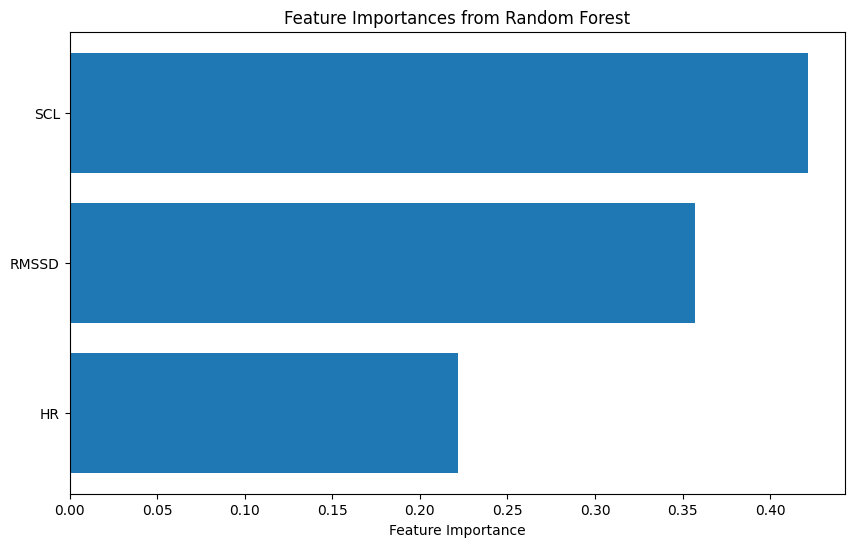

In [10]:
# feature importance analysis
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_


feature_names = np.array(df_features_wesad.columns)

# Create a bar plot of feature importances
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

In [21]:
# using SMOTE

In [23]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Logistic Regression with SMOTE
logistic_model = LogisticRegression(max_iter=1000)
print("Logistic Regression Results with SMOTE:")
train_evaluate_model(logistic_model, X_train_smote, y_train_smote, X_test, y_test)

# Random Forest with SMOTE
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Random Forest Results with SMOTE:")
train_evaluate_model(rf_model, X_train_smote, y_train_smote, X_test, y_test)



Logistic Regression Results with SMOTE:
              precision    recall  f1-score   support

           0       0.30      0.02      0.03      1539
           1       0.31      0.43      0.36       734
           2       0.28      0.35      0.32       401
           3       0.00      0.00      0.00       222
           4       0.21      0.25      0.23       477
           5       0.01      0.11      0.01        28
           6       0.01      0.18      0.02        38
           7       0.00      0.00      0.00        32

    accuracy                           0.18      3471
   macro avg       0.14      0.17      0.12      3471
weighted avg       0.26      0.18      0.16      3471

Cross-validation scores: [0.19639338 0.20685917 0.20055189 0.20055189 0.21099832]
Average CV score: 0.20307092946924205
Random Forest Results with SMOTE:
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      1539
           1       0.78      0.81      0.79   

In [24]:
# Prepare data for LSTM
timesteps = 10  # Adjust this as needed
features = df_features_wesad_standardized.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(df_features_wesad_standardized, df_labels_wesad.values, timesteps)

# Encode the target variable if necessary
label_encoder = LabelEncoder()
y_seq_encoded = label_encoder.fit_transform(y_seq)

# Train-test split for LSTM
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq_encoded, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, features)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[lr_scheduler, early_stopping])

# Evaluate the LSTM model
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq)
print(f'LSTM Test Accuracy: {test_acc}')

Epoch 1/50
347/347 [==============================] - 17s 16ms/step - loss: 1.4898 - accuracy: 0.4596 - val_loss: 1.3681 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 2/50
347/347 [==============================] - 5s 15ms/step - loss: 1.3490 - accuracy: 0.4977 - val_loss: 1.2893 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 3/50
347/347 [==============================] - 6s 17ms/step - loss: 1.2892 - accuracy: 0.5038 - val_loss: 1.2415 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 4/50
347/347 [==============================] - 5s 14ms/step - loss: 1.2407 - accuracy: 0.5137 - val_loss: 1.2194 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 5/50
347/347 [==============================] - 6s 18ms/step - loss: 1.2147 - accuracy: 0.5248 - val_loss: 1.1693 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 6/50
347/347 [==============================] - 5s 16ms/step - loss: 1.1686 - accuracy: 0.5492 - val_loss: 1.1385 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 7/50
347/347 [==============================] - 5s 13ms/s

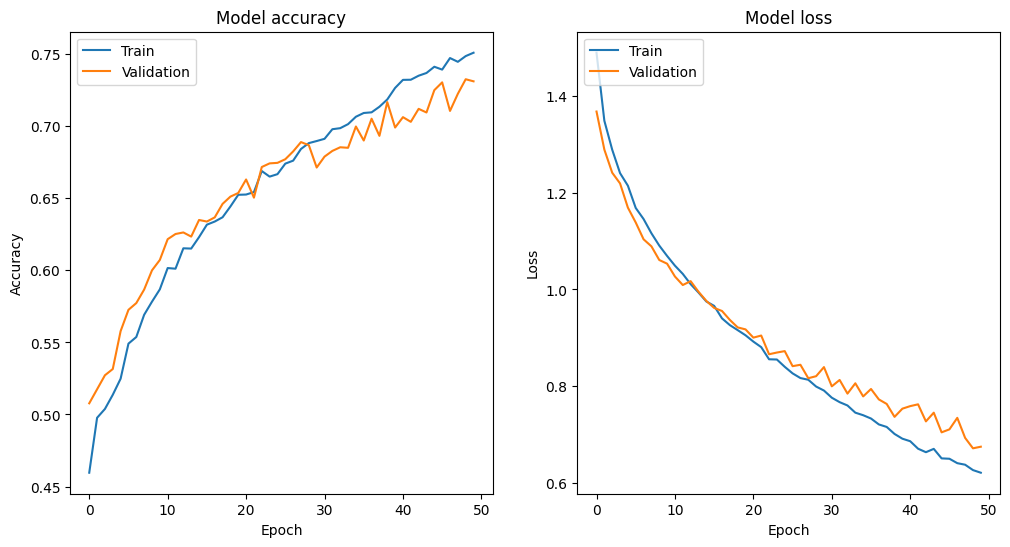

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[lr_scheduler, early_stopping])

# Evaluate the LSTM model
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq)
print(f'LSTM Test Accuracy: {test_acc}')

Epoch 1/50
347/347 [==============================] - 13s 38ms/step - loss: 0.3838 - accuracy: 0.8528 - val_loss: 0.5622 - val_accuracy: 0.7960 - lr: 1.2500e-04
Epoch 2/50
347/347 [==============================] - 11s 31ms/step - loss: 0.3910 - accuracy: 0.8516 - val_loss: 0.5620 - val_accuracy: 0.8007 - lr: 1.2500e-04
Epoch 3/50
347/347 [==============================] - 5s 14ms/step - loss: 0.3917 - accuracy: 0.8463 - val_loss: 0.5550 - val_accuracy: 0.8018 - lr: 1.2500e-04
Epoch 4/50
347/347 [==============================] - 5s 13ms/step - loss: 0.3907 - accuracy: 0.8474 - val_loss: 0.5587 - val_accuracy: 0.7950 - lr: 1.2500e-04
Epoch 5/50
347/347 [==============================] - 7s 19ms/step - loss: 0.3846 - accuracy: 0.8475 - val_loss: 0.5589 - val_accuracy: 0.7968 - lr: 1.2500e-04
Epoch 6/50
347/347 [==============================] - 5s 14ms/step - loss: 0.3934 - accuracy: 0.8450 - val_loss: 0.5655 - val_accuracy: 0.7932 - lr: 1.2500e-04
Epoch 7/50
347/347 [==================

109/109 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1573
           1       0.85      0.87      0.86       705
           2       0.83      0.85      0.84       386
           3       0.72      0.65      0.68       244
           4       0.66      0.72      0.69       470
           5       0.58      0.35      0.44        31
           6       0.47      0.31      0.37        26
           7       0.85      0.32      0.47        34

    accuracy                           0.79      3469
   macro avg       0.72      0.61      0.64      3469
weighted avg       0.79      0.79      0.79      3469



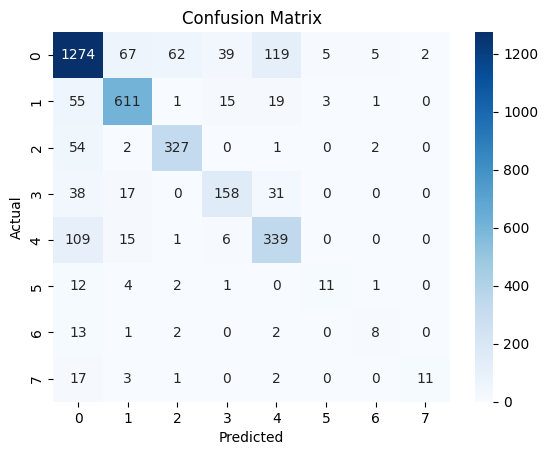

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_probs = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert target names to strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Generate classification report
print(classification_report(y_test_seq, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [32]:
# Generate classification report
report = classification_report(y_test_seq, y_pred, target_names=target_names, output_dict=True)
print(classification_report(y_test_seq, y_pred, target_names=target_names))

# Extract metrics for class 2 (stress)
class_2_metrics = report['2']
precision_2 = class_2_metrics['precision']
recall_2 = class_2_metrics['recall']
f1_score_2 = class_2_metrics['f1-score']

print(f"Class 2 (Stress) - Precision: {precision_2}, Recall: {recall_2}, F1-Score: {f1_score_2}")


              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1573
           1       0.85      0.87      0.86       705
           2       0.83      0.85      0.84       386
           3       0.72      0.65      0.68       244
           4       0.66      0.72      0.69       470
           5       0.58      0.35      0.44        31
           6       0.47      0.31      0.37        26
           7       0.85      0.32      0.47        34

    accuracy                           0.79      3469
   macro avg       0.72      0.61      0.64      3469
weighted avg       0.79      0.79      0.79      3469

Class 2 (Stress) - Precision: 0.8257575757575758, Recall: 0.8471502590673575, F1-Score: 0.8363171355498722
